<a href="https://colab.research.google.com/github/WanQi-K/DataSciencePortfolio/blob/main/Titanic_Project_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
sns.set()

!pip install scikit-learn==1.3.0
!pip install xgboost

from google.colab import drive

drive.mount('/content/drive')
pd.options.display.float_format = '{:.2f}'.format
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path=r'/content/drive/MyDrive/Data Science Data Repository/Titanic/'

titanic_data = pd.read_csv(path+"train.csv")

In [ ]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


# Exploratory Data Analysis (EDA)

In [ ]:
titanic_data.info()
# Age, Cabin missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<function matplotlib.pyplot.show(close=None, block=None)>

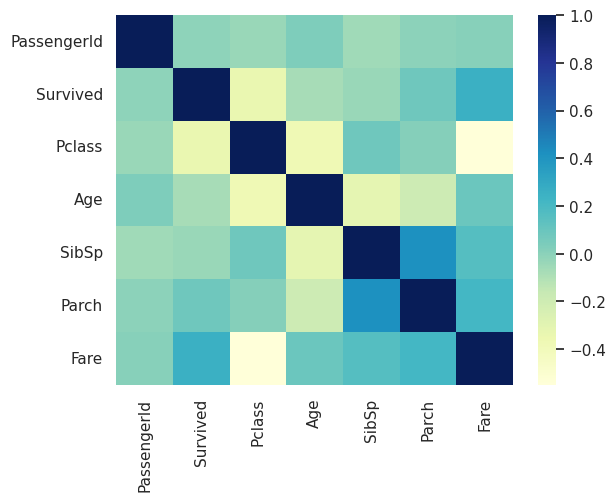

In [ ]:
sns.heatmap(titanic_data.corr(numeric_only=True),cmap="YlGnBu")
plt.show

In [ ]:
# Make sure the data is split equally for the selected Features
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

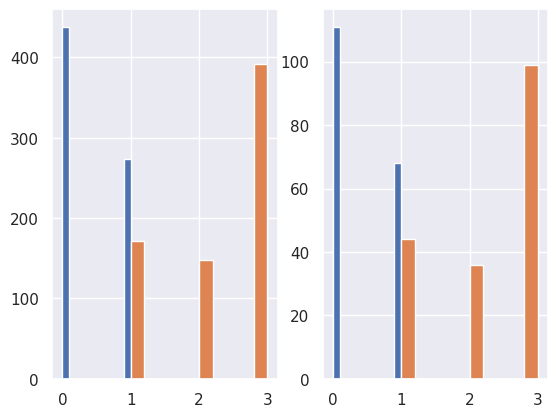

In [ ]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

plt.show()

In [ ]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 867 to 802
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          565 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        167 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


# Data Preparation & Feature Engineering

In [ ]:
# Fill in missing age values with neutral values

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

# Create dummies for selected columns

from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()

        column_names = ["C", "S", "Q", "N"]

        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        matrix = encoder.fit_transform(X[['Sex']]).toarray()

        column_names = ["Female", "Male"]

        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        return X

# Drop columns
class FeatureDropper(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")

In [ ]:
from sklearn.pipeline import Pipeline

pipeline=Pipeline(
    [
     ("age_imputer",AgeImputer()),
     ("feature_encoder",FeatureEncoder()),
     ("feature_dropper",FeatureDropper())
    ]
)

In [ ]:
strat_train_set=pipeline.fit_transform(strat_train_set)
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
867,868,0,1,31.00,0,0,50.50,0.00,0.00,1.00,0.00,1.00
619,620,0,2,26.00,0,0,10.50,0.00,0.00,1.00,0.00,1.00
50,51,0,3,7.00,4,1,39.69,0.00,0.00,1.00,0.00,1.00
286,287,1,3,30.00,0,0,9.50,0.00,0.00,1.00,0.00,1.00
834,835,0,3,18.00,0,0,8.30,0.00,0.00,1.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
482,483,0,3,50.00,0,0,8.05,0.00,0.00,1.00,0.00,1.00
518,519,1,2,36.00,1,0,26.00,0.00,0.00,1.00,1.00,0.00
54,55,0,1,65.00,0,1,61.98,1.00,0.00,0.00,0.00,1.00
603,604,0,3,44.00,0,0,8.05,0.00,0.00,1.00,0.00,1.00


In [ ]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 867 to 802
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


# Model Training

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Data preparation (as you have it)
X = strat_train_set.drop(['Survived'], axis=1)
y = strat_train_set['Survived']

scaler = StandardScaler()
X_train = scaler.fit_transform(X)
y_train = y.to_numpy()

# Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=2000)

# Cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')  # cv=5 for 5 folds

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

# Fit the model on the entire training data (optional)
model.fit(X_train, y_train)


Cross-validation scores: [0.76223776 0.81118881 0.79577465 0.78169014 0.8028169 ]
Average cross-validation score: 0.7907416527134836


LogisticRegression(max_iter=2000, random_state=42)

#Repeat Feature Engineering, Data Modeling, Model Training for test (remaining 20%)

In [ ]:
strat_test_set=pipeline.fit_transform(strat_test_set)

# Data preparation
X = strat_test_set.drop(['Survived'], axis=1)
y = strat_test_set['Survived']

scaler = StandardScaler()
X_test = scaler.fit_transform(X)
y_test = y.to_numpy()

# Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=2000)

# Cross-validation
scores = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')  # cv=5 for 5 folds

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

# Fit the model on the entire training data (optional)
model.fit(X_test, y_test)


Cross-validation scores: [0.69444444 0.83333333 0.77777778 0.83333333 0.82857143]
Average cross-validation score: 0.7934920634920635


LogisticRegression(max_iter=2000, random_state=42)

# Repeat Feature Engineering, Model Training for whole train dataset

In [ ]:
final_train_data = pipeline.fit_transform(titanic_data)

In [ ]:
final_train_data.info()
# No nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   C            891 non-null    float64
 8   S            891 non-null    float64
 9   Q            891 non-null    float64
 10  Female       891 non-null    float64
 11  Male         891 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 83.7 KB


In [ ]:
# Data preparation
X = final_train_data.drop(['Survived'], axis=1)
y = final_train_data['Survived']

scaler = StandardScaler()
X_final = scaler.fit_transform(X)
y_final = y.to_numpy()

# Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=2000)

# Cross-validation
scores = cross_val_score(model, X_final, y_final, cv=5, scoring='accuracy')  # cv=5 for 5 folds

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

# Fit the model on the entire training data (optional)
model.fit(X_final, y_final)

Cross-validation scores: [0.78212291 0.78089888 0.78089888 0.76966292 0.80337079]
Average cross-validation score: 0.783390873140418


LogisticRegression(max_iter=2000, random_state=42)

Can we determine whats the best estimators?

In [ ]:
# Additional hyperparameter tuning

from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']  # Use solvers that support 'l1'
}

lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}


# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to your data
grid_search.fit(X_final, y_final)

# Print the best hyperparameters and score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use the best model for predictions
best_model = grid_search.best_estimator_

Best hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best score: 0.789008850668508


# Repeat process on Test Data

In [ ]:
# Apply on the test data
titanic_test_data = pd.read_csv(path+"test.csv")

#Feature Engineer
final_test_data = pipeline.fit_transform(titanic_test_data)

#Fill NA
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")

#Standard Scaler
scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   Female       418 non-null    float64
 10  Male         418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.1 KB


<ipython-input-361-ffe258278eb0>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method="ffill")


In [ ]:
# Directly fit into ML model
prediction = model.predict(X_data_final_test)

In [ ]:
prediction

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
# Save it in CSV
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = prediction
final_df.to_csv(path+"LogisticRegression_predictions.csv", index=False)
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
